In [1]:
# import relevant libraries
from src import common

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats

import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

In [2]:
print(dir(common))

['ARIMA', 'Stationarity_analysis', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np', 'pd', 'plot_acf', 'plot_pacf', 'plt', 'serial_corr', 'serial_corr_all_lags', 'sm', 'sns', 'statsmodels', 'test_het', 'test_norm', 'tsa']


In [3]:
# load Consumer Price Index for Israel

cpi = pd.read_csv('ISRCPIALLQINMEI.csv', names=['date','amount'], header=0)
print(cpi.dtypes)
print(cpi.head())

# change dates to datetime index
cpi['date'] = pd.to_datetime(cpi['date'], format='%Y-%m-%d')
cpi.set_index('date', inplace=True)
print("------------------ CPI for Israel ----------------------")
print(cpi)
print("---------------------------------------------------------")

date       object
amount    float64
dtype: object
         date     amount
0  2001-01-01  75.436828
1  2001-04-01  76.478495
2  2001-07-01  77.318548
3  2001-10-01  77.217742
4  2002-01-01  78.393817
------------------ CPI for Israel ----------------------
                amount
date                  
2001-01-01   75.436828
2001-04-01   76.478495
2001-07-01   77.318548
2001-10-01   77.217742
2002-01-01   78.393817
...                ...
2021-10-01  103.259409
2022-01-01  104.301075
2022-04-01  106.283602
2022-07-01  107.829301
2022-10-01  108.635753

[88 rows x 1 columns]
---------------------------------------------------------


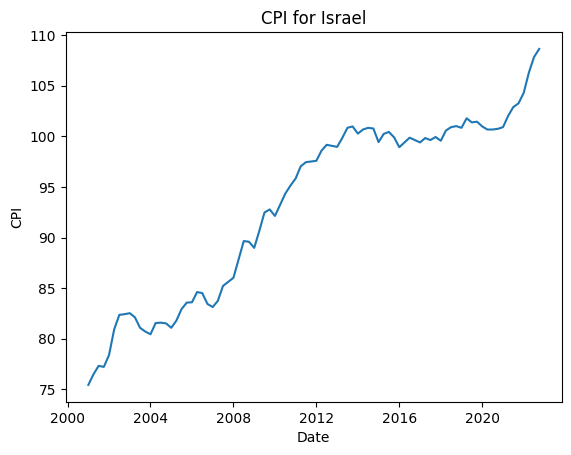

In [4]:
# plotting the series
plt.plot(cpi.amount)
plt.title('CPI for Israel')
plt.ylabel('CPI')
plt.xlabel('Date')
plt.show()

In [5]:
# Preparing the data to check different transformations
y = cpi.amount
dy = y.diff().dropna()
ddy = y.diff().dropna().diff().dropna()
ly = np.log(y)
dly = np.log(y).diff().dropna()
ddly = np.log(y).diff().dropna().diff().dropna()

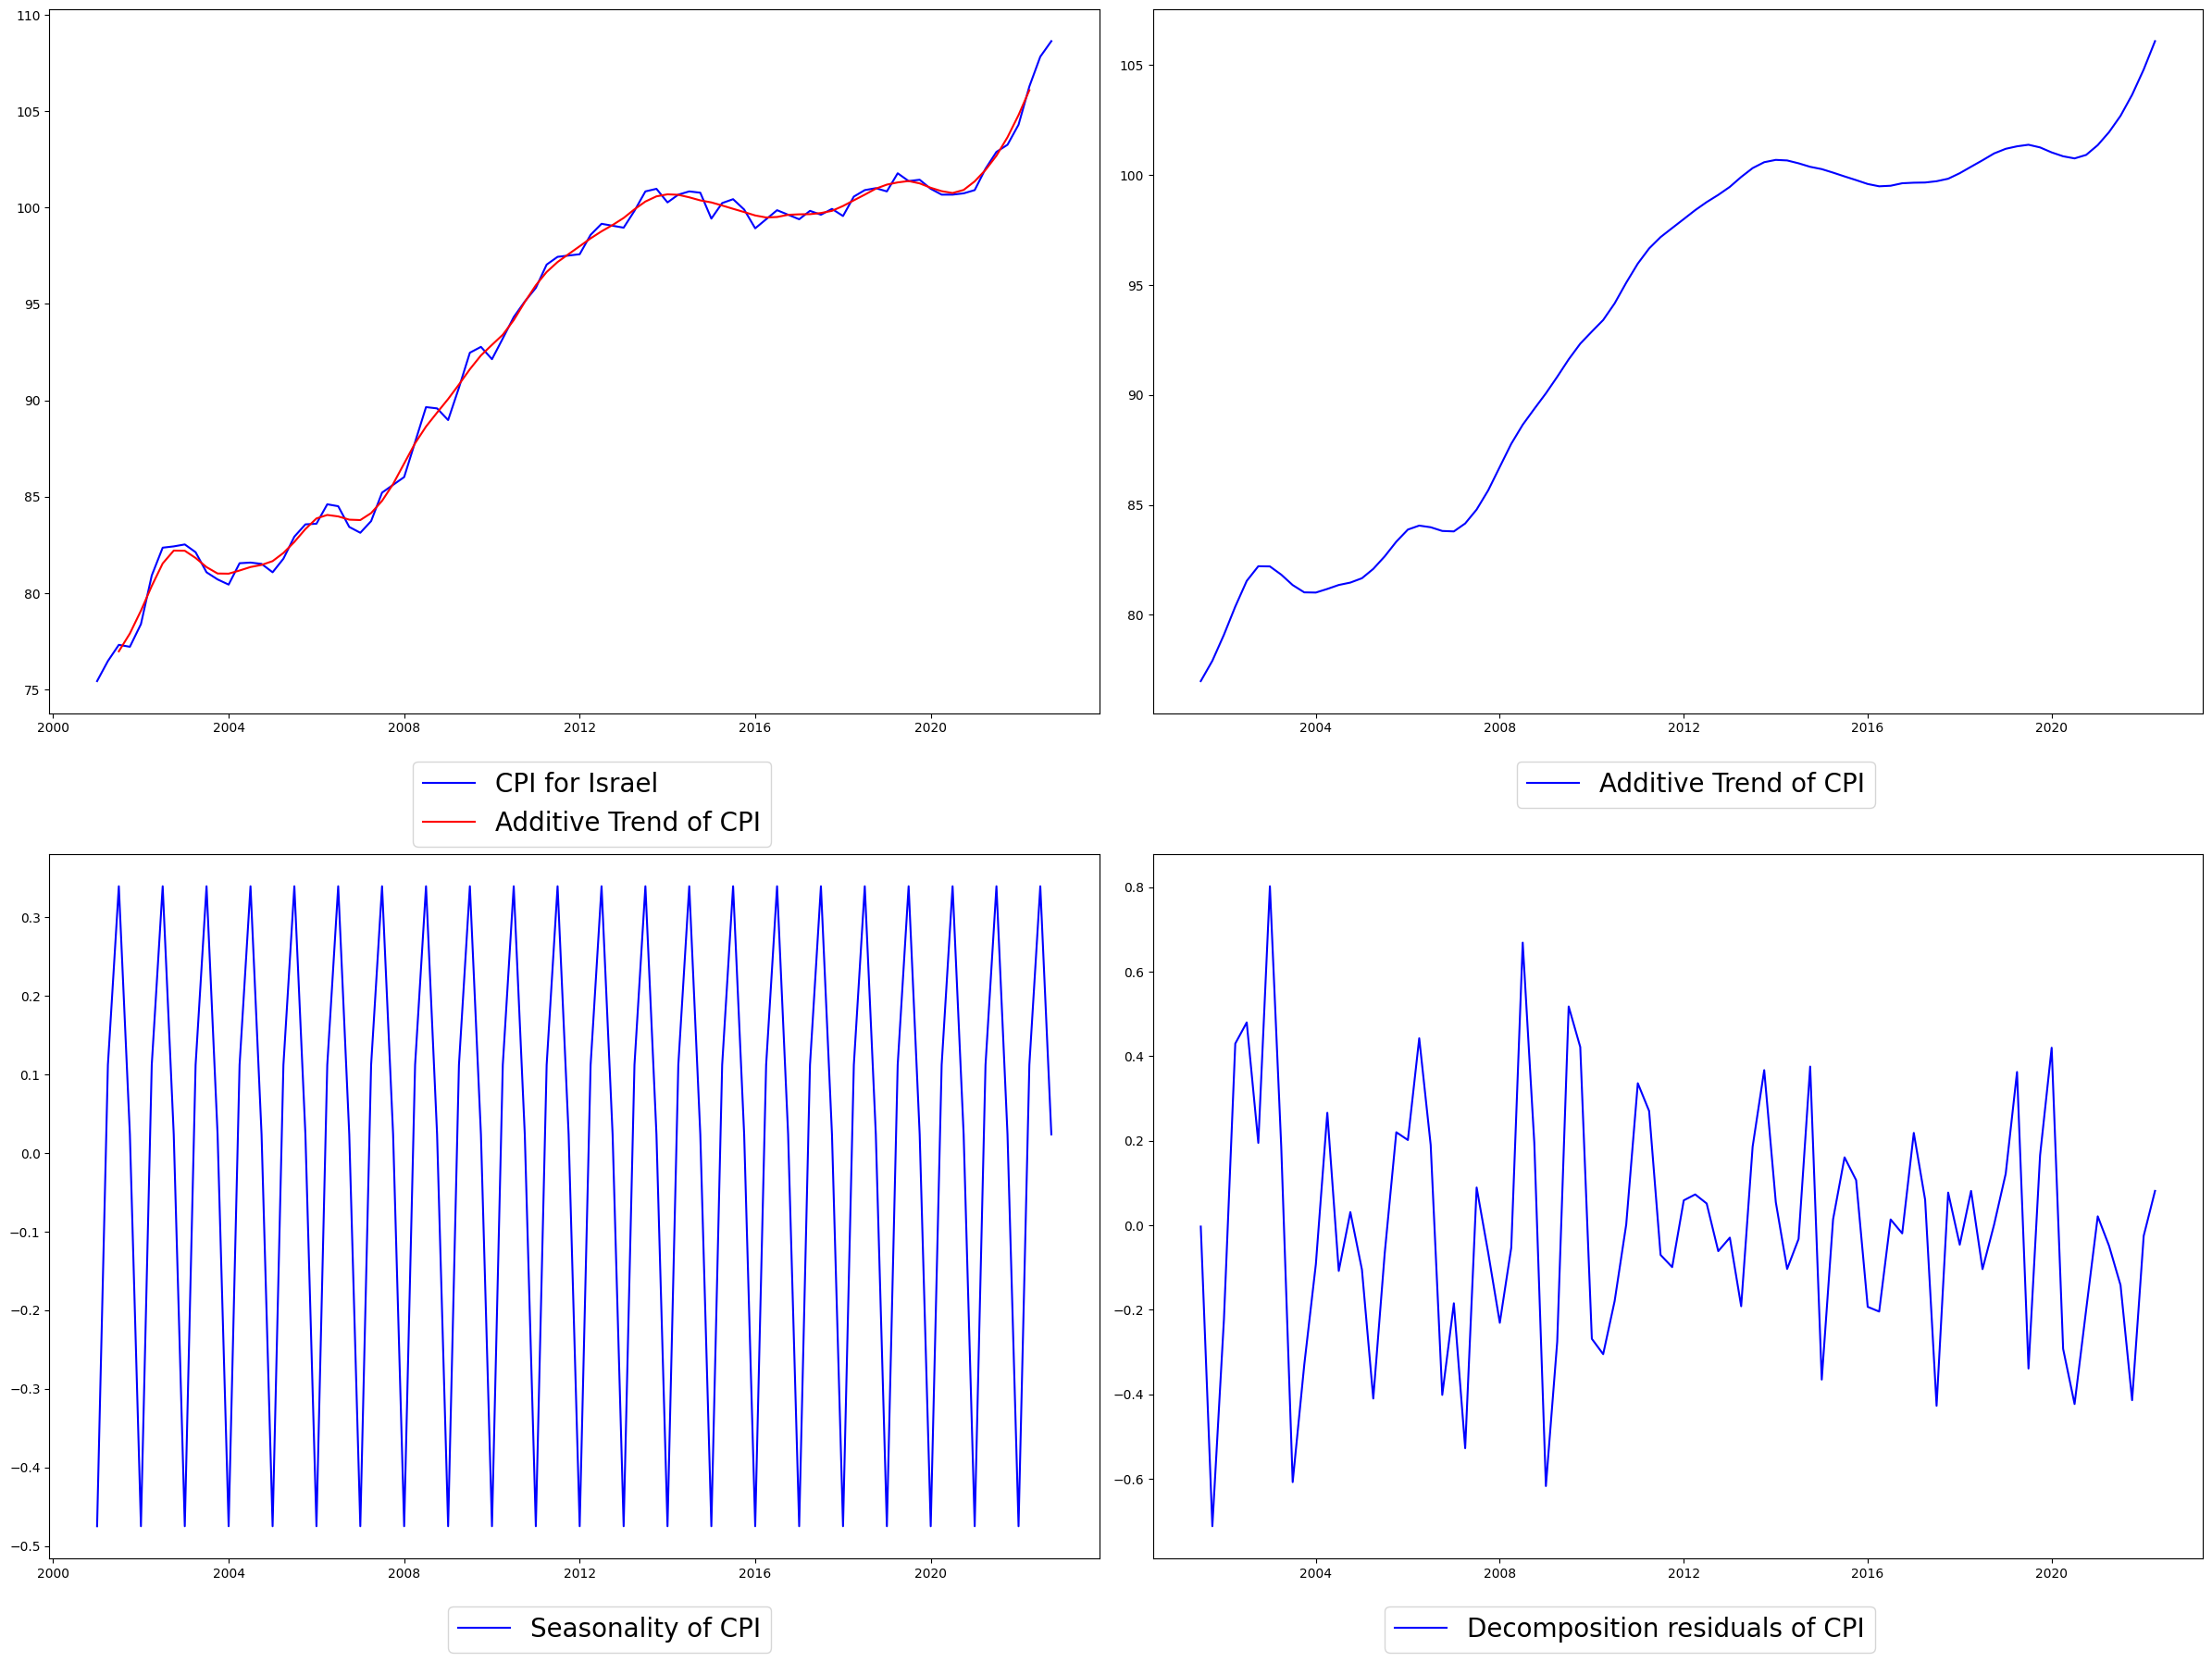

In [6]:
# decompose the series - additive model
additive = seasonal_decompose(y, model='additive')
trend_estimate = additive.trend
periodic_estimate = additive.seasonal
residual = additive.resid

plt.rcParams["figure.figsize"] = (24,18)
plt.subplot(221)
plt.plot(cpi.amount ,label='CPI for Israel', color='blue')
plt.plot(trend_estimate ,label='Additive Trend of CPI' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(trend_estimate,label='Additive Trend of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(periodic_estimate,label='Seasonality of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(residual,label='Decomposition residuals of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

#### Comments:
A visual examination of the time series and its different components decomposed using the additive model shows that the residual could already be stationary after decomposition. Nevertheless, since the variability of the seasonal component is very low, ranging from -0.5 to 0.3 (0.8 across) it is hard to suggest an actual seasonal component existed in the original series. Additionaly, the trend resembles a stochastic trend more than a deterministic trend. Therefore, this might prove not to be the right approach to obtain stationarity in the time series, and taking a difference could yield better results. 

In [7]:
# create a df of the additive model
additive_components = pd.DataFrame([additive.observed, additive.trend,
                                    additive.seasonal, additive.resid]).T
additive_components.columns = ["observed", "trend", "seasonal", "resid"]
additive_components['sum'] = additive_components.sum(numeric_only=True, axis=1)
additive_components['product'] = additive_components.loc[:,"trend":"resid"].product(axis=1, numeric_only=True)

In [8]:
# check stationarity for residuals
y_add_resid = additive_components.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_add_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_add_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_add_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_add_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 4.209624283724807e-15
    (2) ADF p-value (const + trend): 1.3848848309946499e-13
    (3) ADF p-value (const + trend + quad trend): 7.235945666946525e-13
    (4) ADF p-value (no const + no trend): 8.369164143989653e-16


#### Comments:
As was suspected by observing the plots, the residuals of the time series are indeed stationary after removing the trend and seasonality, with a p-value being ~0 for each underlying model. To examine the time series further, the CPI time series will be decomposed with STL to allow for non-linear seasonality patterns.

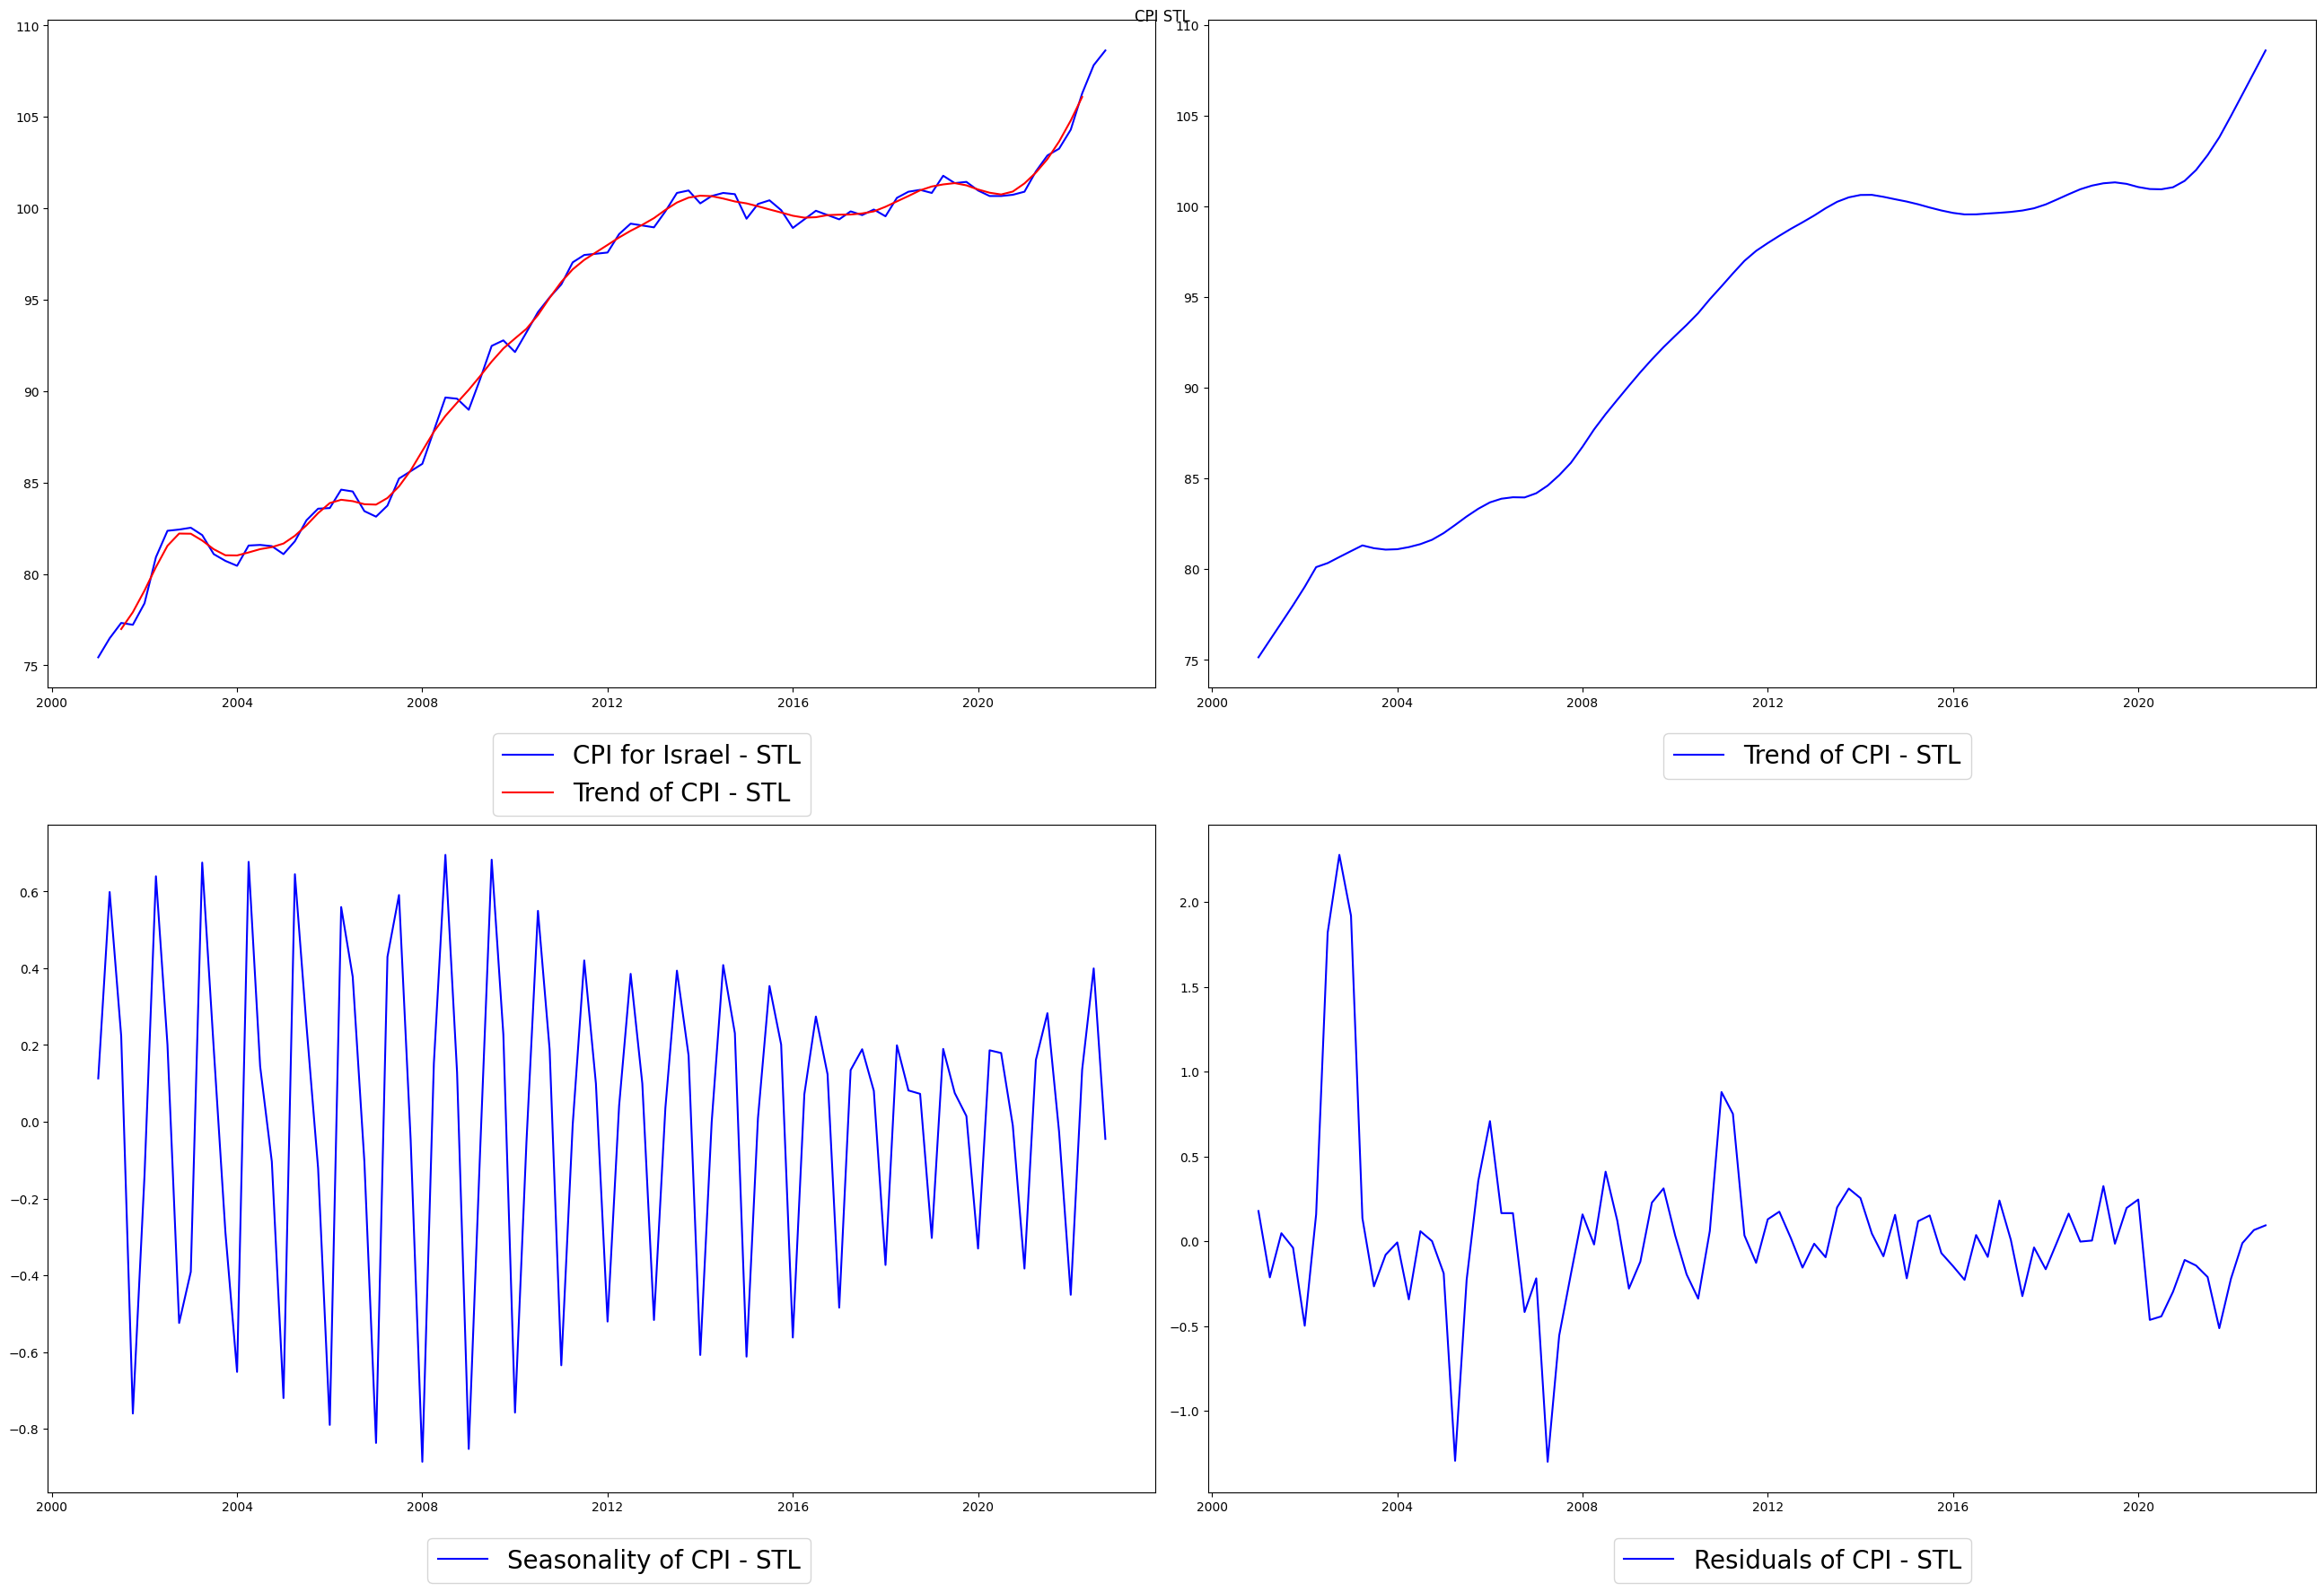

In [9]:
# decompose with STL
cpi_stl = STL(y, robust=True).fit()

plt.rcParams["figure.figsize"] = (26,18)
plt.suptitle('CPI STL', )
plt.subplot(221)
plt.plot(cpi_stl.observed ,label='CPI for Israel - STL', color='blue')
plt.plot(trend_estimate ,label='Trend of CPI - STL' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(cpi_stl.trend ,label='Trend of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(cpi_stl.seasonal ,label='Seasonality of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(cpi_stl.resid ,label='Residuals of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

#### Comments:
As can be seen on the seasonality plot, STL allows for different patterns of seasonality to be expressed, growing and reducing in size along the x axis. The variability of the seasonality, nevertheless, is still low. The tren plot is very similar to the one obtained with the additive decomposition. Since this method is able to more percisely seperate the seasonal pattern from the trend, the effect of de-seasoning the series might not be as strong as before, resulting in non-stationary residuals. A formal test of the underlying models can be viewed below.

In [10]:
# check stationarity for residuals
y_resid = cpi_stl.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 0.00031876519857332867
    (2) ADF p-value (const + trend): 0.00038209689433912165
    (3) ADF p-value (const + trend + quad trend): 0.06112834179042951
    (4) ADF p-value (no const + no trend): 1.8437192586137755e-05


#### Comments:
The formal tests with a constant, constant and trend and no constant and no trend all suggest that the residuals are now stationary at α = 0.01 significance level. On the other hand, the test for constant, trend and quadratic trend (yt = α + βt + γt2 + εt) suggests that the series is still not stationary. This underlying model looks for a trend stationarity, which suggests that the residuals still have a trend after decompositioning.


STATIONARITY ANALYSIS FOR: De-seasoned Series with STL

------------------------------- (1) Time series plot -------------------------------


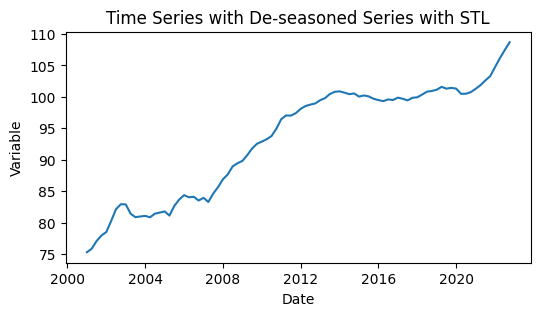

------------------------------- (2) ACF and PACF plot -------------------------------


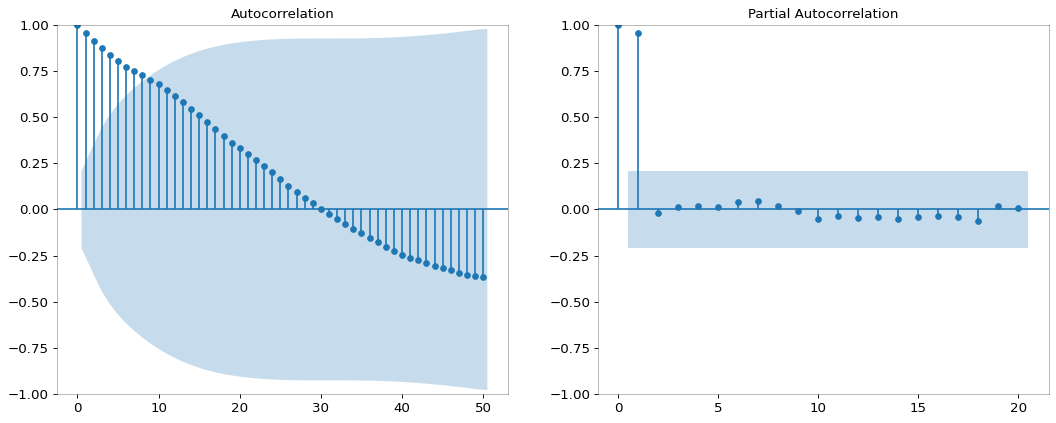

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 0.8986765940643631
    (2) ADF p-value (const + trend): 0.5375936044443081
    (3) ADF p-value (const + trend + quad trend): 0.8192736952118423
    (4) ADF p-value (no const + no trend): 0.988996503578044


In [11]:
# plot time series, autocorrelation and partial-autocorrelation functions of deseasoned series
y_deseasoned = y - cpi_stl.seasonal
title = 'De-seasoned Series with STL'
common.Stationarity_analysis(y_deseasoned, title)


#### Comments:
By removing the seasonal component alone, the autocorrelation function shows a very strong trend, decaying slowly and continuing to grow in an almost linear pattern. The first partial autocorrelation is very high, with all subsequent partial autocorrelations insignificant. Accorfing to the ADF test, the de-seasoned series cannot be considered stationary for all underlying models. These results are in line with the initial analysis showing that the variability of the seasonal component is low and it cannot account for most of the non-stationarity in the time series.

Since the series appears to have a stochastic and the seasonal component is very small, a difference of the time series will be taken to transform the series into a stationary one.


STATIONARITY ANALYSIS FOR: 2nd Difference of the De-seasoned Series

------------------------------- (1) Time series plot -------------------------------


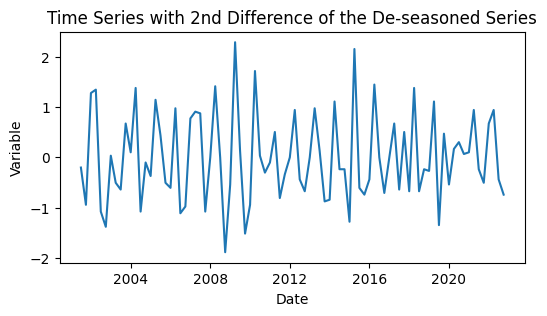

------------------------------- (2) ACF and PACF plot -------------------------------


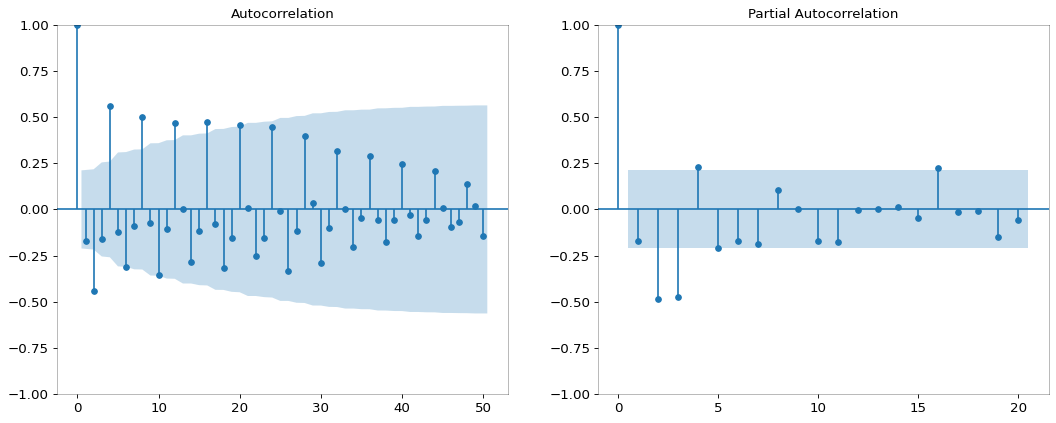

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 1.1522185954180465e-06
    (2) ADF p-value (const + trend): 6.794068306827363e-06
    (3) ADF p-value (const + trend + quad trend): 3.433729400069134e-05
    (4) ADF p-value (no const + no trend): 4.884777665096971e-08


In [12]:
# plot time series, autocorrelation and partial-autocorrelation functions of the de-seasoned and differenced series
title = '2nd Difference of the De-seasoned Series'
common.Stationarity_analysis(ddy, title)



#### Comments:
Following the assumption that the CPI time series is difference stationary integrated of 2nd order, it appears that the transformation indeed results in stationarity. By taking the 2nd difference, the residuals are now stationary according to the ADF tests for all underlying models. Meanwhile, the ACF plot shows that autocorrelation is decaying with each lag, while PACF is significant up to the 3rd lag. Therefore, this transformation will be assessed onwards by potential ARMA models up to p=4 and q=3.

In [28]:
for i,j in [(1, 1), (2, 1), (3, 1), (4, 1), (1, 2), (2, 2), (3, 2), (4, 2), (1, 3), (2, 3), (3, 3), (4, 3)]:
    model = ARIMA(ddy, order=(i, 0, j))
    model_results = model.fit()
    print(f'Summary of the Estimated ARMA ({i}, {j}) Model :')
    print(model_results.summary())

    # test for heteroskedasticity
    common.test_het(model_results)

    # test normality of errors
    common.test_norm(model_results)

    # test serial correlation with Ljung-Box Q and Ljung-Box Q*
    common.serial_corr(model_results, 12)

    common.serial_corr_all_lags(model_results, 12)


Summary of the Estimated ARMA (1, 1) Model :
                               SARIMAX Results                                
Dep. Variable:                 amount   No. Observations:                   86
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -94.668
Date:                Tue, 23 May 2023   AIC                            197.336
Time:                        14:51:27   BIC                            207.154
Sample:                    07-01-2001   HQIC                           201.287
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.007     -0.296      0.767      -0.015       0.011
ar.L1          0.3492      0.104      3.367      0.001       0.146       0.553
ma.L1  

# Ljung-Box Q* test and Box-Pierce Test
#### In order to check for serial correlation of lags up to largest lag: 
*"If lags is a list or array, then all lags are included up to the largest lag in the list, however only the tests for the lags in the list are reported."*

#### From https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html



In [66]:
# Ljung-Box Q* test
sm.stats.acorr_ljungbox(model_results.resid, lags=[12], return_df=True, model_df=4, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,8.870429,0.353344,7.989313,0.434515


### Description
#### Ljung-Box: 

<img align="right" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/df44d87dccf7b56d16ceae7c44880053de9ff3a7"
     alt="Ljung-Box Formula"
     style="clear: both; margin-right: 10px; background-color: white;" />

* A portmanteau test, where:
    * H0: the data is independently distributed (for all lags up to tested lag jointly).
    * H1: the data exhibits some serial correlation.
* The results  are compared to a  χ2 distribution with h degrees of freedom (where h is the number of lags being tested)
* When used to test the model residuals, the degrees of freedom are deducted the number of estimated parameters in the ARMA model (p and q)
* It can be described as a weighted sum of squared autocorrelations at lags 1 through h
* A significant result (a result with p-value smaller than a given alpha) indicate a significant autocorrelation in the data for the given lags

#### Box-Pierce:

<img align="right" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cf757b9bfb96d2980b0536f9758aeb49ae06a631"
     alt="Box-Pierce Formula"
     style="clear: both; margin-right: 10px; background-color: white;" />

* Similarly to Ljung-Box, it is a portmanteau test, where:
    * H0: the data is independently distributed (for all lags up to tested lag jointly).
    * H1: the data exhibits some serial correlation.
* It is similar to the Ljung-Box test in certain features:
    * Q statistic with m degrees of freedom (minus the number of estimated parameters for ARMA model)
    * The results are compared to a  χ2. When testing the residuals of an ARMA model, the distribution has h-p-q degrees of freedom.
* It differs from the Ljung-Box test (which was developed to answer the deficiency in Box-Pierce), by the fact that it is shown to considerably deviate from a χ2 distribution for all sample sizes, including moderate and small smaples.
    * The imperfection of the Box-Pierce test raises the risk of commiting a type 1 error (Ray and Xiaolou)
    * To resolve this, a weighted term is added to the Ljung-Box test (and subsequent models which attempted to prevent the test's over-correction, e.g. Fisher, 2011 or Monti, 1994)

